In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import re

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel
from gensim.models.nmf import Nmf

from collections import OrderedDict

In [2]:
data_file = "./dreaddit/dreaddit-train-allTexts.csv"
train_df = pd.read_csv(data_file)
train_df.head()
print(train_df.shape)

(2838, 3)


## EDA

In [3]:
# How many human annotated topics are in the data?
stress_topics = list(set(train_df['subreddit'].tolist()))
print("Number of stress topics in the data: {}".format(len(stress_topics)))

Number of stress topics in the data: 10


In [4]:
# the shape of the data: how many tweets are in the data set?
print("Shape of the data: {}".format(train_df.shape))

Shape of the data: (2838, 3)


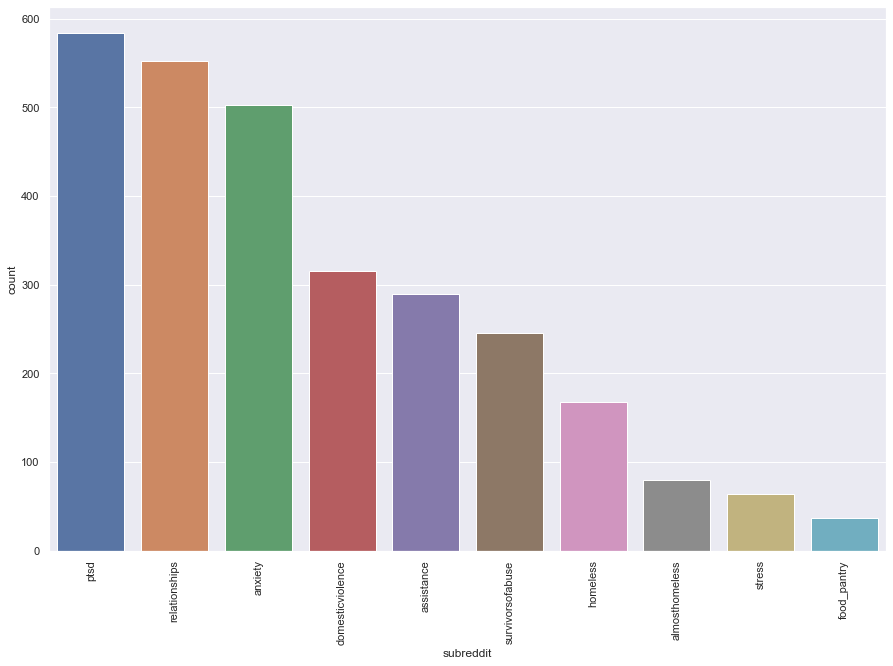

In [5]:
# the distributions of stress topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='subreddit', data=train_df, order = train_df['subreddit'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

Because some subreddits are more or less popular, the amount of data in each domain varies. We include ten total subreddits from five domains in our dataset. 

In [6]:
def getDomainsfromTopics(topic):
    if topic in ['domesticviolence', 'survivorsofabuse']:
        return 'abuse'
    elif topic in ['anxiety', 'stress']:
        return 'anxiety'
    elif topic in ['almosthomeless', 'assistance', 'food_pantry', 'homeless']:
        return 'financial'
    elif topic == 'ptsd':
        return 'PTSD'
    elif topic == 'relationships':
        return 'social'

train_df['domains'] = train_df.apply(lambda x: getDomainsfromTopics(x.subreddit), axis=1)
train_df.head()

,subreddit,text,sentiment,domains
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse


In [7]:
# How many stress domains are in the data now?
stress_domains = list(set(train_df['domains'].tolist()))
print("Number of stress domains in the data: {}".format(len(stress_domains)))

Number of stress domains in the data: 5


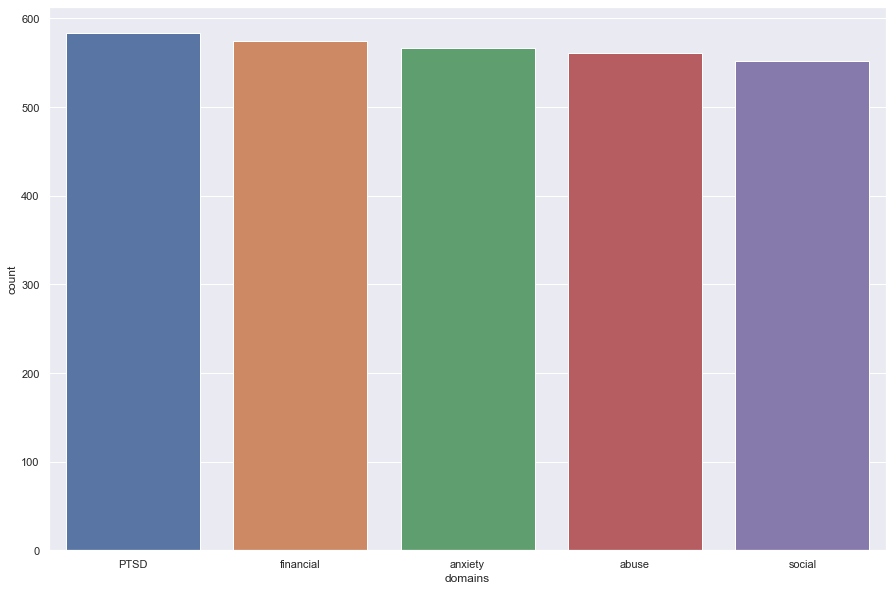

In [8]:
# the distributions of stress domains in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_domain = sns.countplot(x='domains', data=train_df, order = train_df['domains'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [9]:
def getSentiLabelFromScores(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
train_df['senti_label'] = train_df.apply(lambda x: getSentiLabelFromScores(x.sentiment), axis=1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


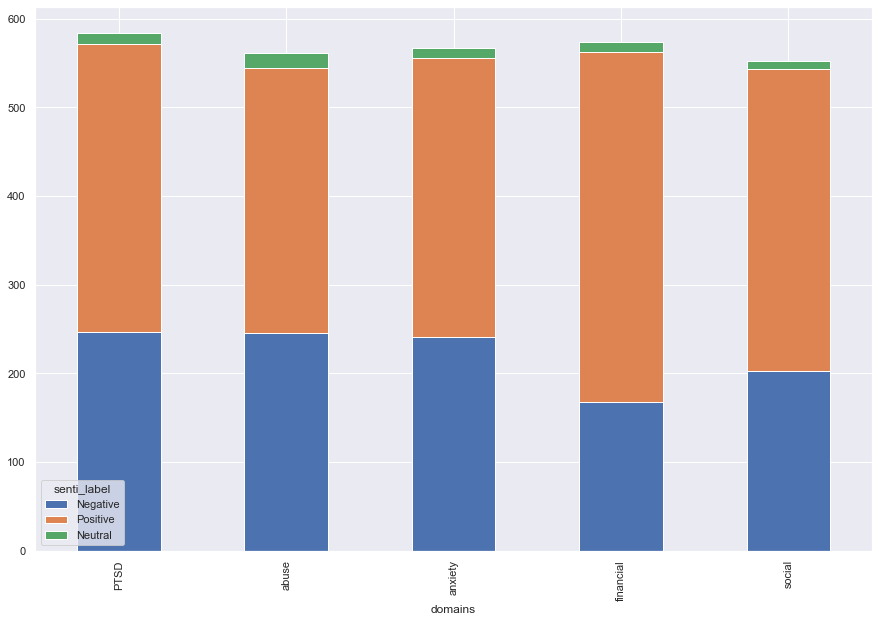

In [10]:
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

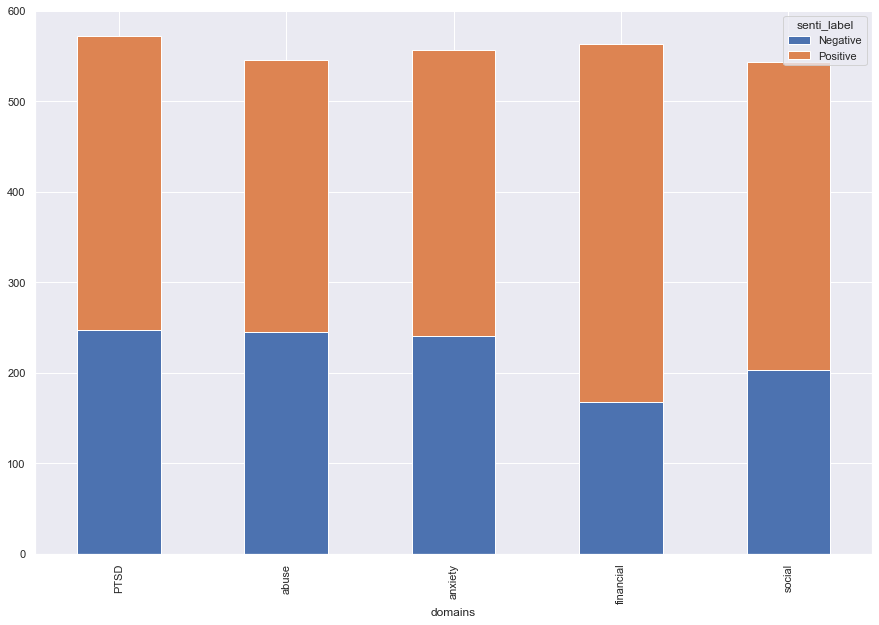

In [11]:
# drop Neutral rows since there are too few records
train_df = train_df.loc[train_df.senti_label != 'Neutral']
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

In [12]:
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


## Model

In [13]:
# Prepare the corpus for analysis
def preprocess_text(text, stem=False):
    """Preprocess one sentence: tokenizes, lowercases, applies the Porter stemmer,
     removes punctuation tokens and stopwords.
     Returns a list of strings."""
    toks = word_tokenize(text)
    # clean
    stops = stopwords.words('english')
    selfdefined_stops = ["n't", "the", "it", "get", "got", "gets", 
                         "my", "also", "one", "could", "would", "can", 
                         "as", "said", "go", "goes", "going", "went", 
                         "also", "is", "since", "these", "so", "really", 
                         "much", "what", "the", "still", "every", "any", 
                         "it", "make", "but" , "my", "like", "know", 
                         "something", "even", "tell", "told", "things", 
                         "feel", "want", "think", "take", "back", "never", 
                         "first", "last", "ca", "us", "thing", "always", 
                         "made", "else", "dont", "im", "find", "though", 
                         "let", "way", "come", "ever", "lot", "good", "bad", 
                         "maybe", "two", "little", "start", "try", "apparently", 
                         "joe", "seem", "give", "please", "next", "able", "put", 
                         "although", "etc", "long", "url", "say", "see", "sometimes",
                         "around", "another", "bit", "x200b", "edit", "ask"]
    stopwords_list = stops + selfdefined_stops
    # stem
    if stem:
        stemmer = PorterStemmer()
        toks = [stemmer.stem(tok) for tok in toks]
    toks = [manual_stem(tok) for tok in toks]
    # remove punctuation
    toks_nopunc = [tok.lower() for tok in toks if tok not in string.punctuation]
    # remove stopwords
    toks_nostop = [tok for tok in toks_nopunc if tok not in stopwords_list]
    toks_tidy = [tok for tok in toks_nostop if re.match(r'[a-zA-Z]+', tok) and len(tok) >= 3]
    return toks_tidy

In [14]:
def manual_stem(tok):
    if tok in ['trying', 'tried', 'tries']:
        return 'try'
    if tok in ['getting', 'got', 'gets']:
        return 'get'
    if tok in ['made', 'making', 'makes']:
        return 'make'
    if tok in ['took', 'taking', 'takes']:
        return 'take'
    if tok in ['wanted', 'wants']:
        return 'want'
    if tok in ['goes', 'went', 'going']:
        return 'go'
    if tok in ['told', 'telling', 'tells']:
        return 'tell'
    if tok in ['feeling', 'felt', 'feels', 'feelings']:
        return 'feel'
    if tok in ['found', 'finds']:
        return 'find'
    if tok in ['asked', 'asks', 'asking']:
        return 'ask'
    if tok in ['seems', 'seemed']:
        return 'seem'
    if tok in ['working', 'worked', 'works']:
        return 'work'
    if tok in ['starting', 'started', 'starts']:
        return 'start'
    if tok in ['coming', 'came', 'comes']:
        return 'come'
    if tok in ['best', 'well']:
        return 'good'
    if tok in ['called', 'calls']:
        return 'call'
    if tok in ['thinking', 'thought', 'thinks']:
        return 'think'
    if tok in ['trying', 'tried', 'tries']:
        return 'try'
    if tok == 'years':
        return 'year'
    if tok == 'months':
        return 'month'
    if tok == 'days':
        return 'day'
    if tok == 'friends':
        return 'friend'
    if tok == 'thanks':
        return 'thank'
    if tok == 'jobs':
        return 'job'
    else:
        return tok

In [15]:
train_df['text'] = train_df.apply(lambda x: preprocess_text(x.text), axis = 1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"[suggeted, rest, trigger, ahead, youi, hypocon...",-0.002742,PTSD,Negative
1,assistance,"[hey, r/assistance, sure, right, place, post, ...",0.292857,financial,Positive
2,ptsd,"[mom, hit, newspaper, shocked, knows, play, hi...",0.011894,PTSD,Positive
3,relationships,"[met, new, boyfriend, amazing, kind, sweet, st...",0.141671,social,Positive
4,survivorsofabuse,"[october, domestic, violence, awareness, month...",-0.204167,abuse,Negative


In [16]:
# wordcloud
# Import the wordcloud library
from wordcloud import WordCloud

In [17]:
long_string = ''
string_list = train_df['text'].apply(lambda x: ' '.join([w for w in x]))
long_string = long_string.join([line for line in string_list])
long_string

"suggeted rest trigger ahead youi hypocondriac decide look doom hopes sucked rabbit hole ludicrous conspiracy stupid psychic test new age b.s. laugh road ended reading sense doom indicative various health ailments prone top doom gloom worried heart happen physical hourshey r/assistance sure right place post currently student intern sandia national labs work survey help improve marketing outreach efforts many schools recruit country looking current undergrad/grad stem students stem student stem students greatly appreciate help pass along short survey thank everyone helps survey entered drawing chance win three amazon gcsmom hit newspaper shocked knows play hitting smacking striking hitting violence sort person send vibe universe yesterday decided friend help friend move new place driving friend moving strikes shoulder address immediately time friend driving nearly collision car high marijuana friend moving backseat understand attention year olds peoples attention smacking guymet new boy

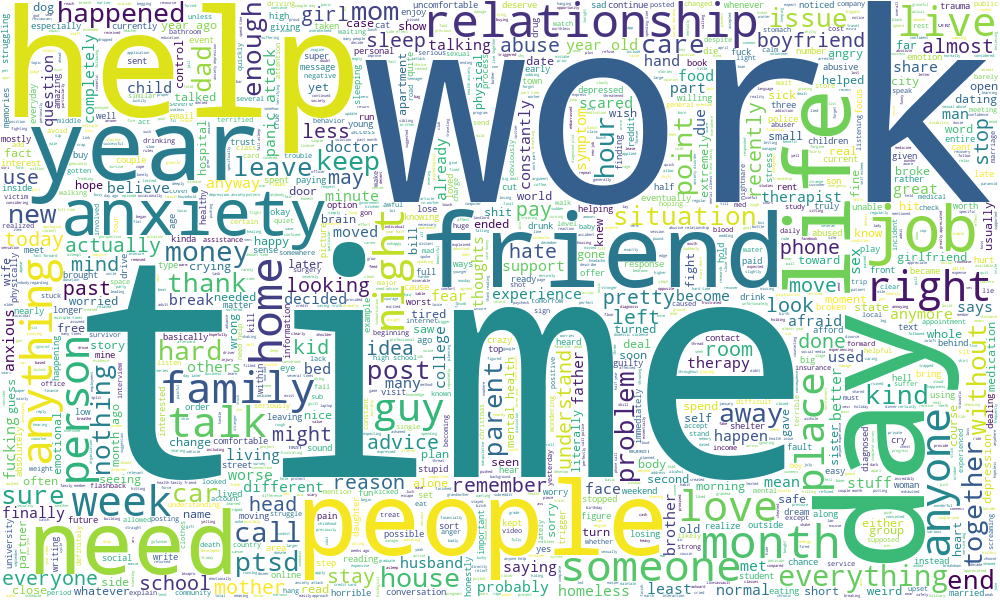

In [18]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=2000,
                      contour_color='steelblue', 
                      width=1000, height=600)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [19]:
texts = train_df['text']
dictionary = corpora.Dictionary(texts)
print(dictionary.token2id)

{'age': 0, 'ahead': 1, 'ailments': 2, 'b.s.': 3, 'conspiracy': 4, 'decide': 5, 'doom': 6, 'ended': 7, 'gloom': 8, 'happen': 9, 'health': 10, 'heart': 11, 'hole': 12, 'hopes': 13, 'hours': 14, 'hypocondriac': 15, 'indicative': 16, 'laugh': 17, 'look': 18, 'ludicrous': 19, 'new': 20, 'physical': 21, 'prone': 22, 'psychic': 23, 'rabbit': 24, 'reading': 25, 'rest': 26, 'road': 27, 'sense': 28, 'stupid': 29, 'sucked': 30, 'suggeted': 31, 'test': 32, 'top': 33, 'trigger': 34, 'various': 35, 'worried': 36, 'youi': 37, 'along': 38, 'amazon': 39, 'appreciate': 40, 'chance': 41, 'country': 42, 'current': 43, 'currently': 44, 'drawing': 45, 'efforts': 46, 'entered': 47, 'everyone': 48, 'gcs': 49, 'greatly': 50, 'help': 51, 'helps': 52, 'hey': 53, 'improve': 54, 'intern': 55, 'labs': 56, 'looking': 57, 'many': 58, 'marketing': 59, 'national': 60, 'outreach': 61, 'pass': 62, 'place': 63, 'post': 64, 'r/assistance': 65, 'recruit': 66, 'right': 67, 'sandia': 68, 'schools': 69, 'short': 70, 'stem': 71

In [20]:
# A major question in using LDA for topic modeling is what is is the proper set of
# hyperparmeters to generate the optimal set of topics for the coprus of documents
# under examination. Gensim includes methods for computing the Perplexity and Topic 
# Coherence of a corpus. One appraoch is to sample an LDA model for a range of 
# for perplexity and topic coherence and select the appropriate number of topics
# from a point of minimum perplexity and maximium topic coherence.

corpus = [dictionary.doc2bow(text) for text in texts]

# However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, 
# and even sometimes slightly anti-correlated.
# So only using coherence score to evaluate models in our project
# perplexity_lda = []
coherence_lda = []
topic_count_lda = []

for num_topics in range(2, 16, 1):
    
    print("Computing the lda model using {} topics".format(num_topics))
    
    topic_lda = models.LdaModel(corpus,
                                id2word = dictionary,
                                num_topics = num_topics,
                                iterations = 1000,
                                alpha = 'auto')
    corpus_lda = topic_lda[corpus] # Use the bow corpus
    
    topic_count_lda.append(num_topics)
    
#     # a measure of how good the model is. the lower, the better.
#     perplexity_lda.append(topic_lda.log_perplexity(corpus))

    # Compute Coherence Score
    cm = CoherenceModel(model=topic_lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence_lda.append(cm.get_coherence())

Computing the lda model using 2 topics
Computing the lda model using 3 topics
Computing the lda model using 4 topics
Computing the lda model using 5 topics
Computing the lda model using 6 topics
Computing the lda model using 7 topics
Computing the lda model using 8 topics
Computing the lda model using 9 topics
Computing the lda model using 10 topics
Computing the lda model using 11 topics
Computing the lda model using 12 topics
Computing the lda model using 13 topics
Computing the lda model using 14 topics
Computing the lda model using 15 topics


In [21]:
# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'coherence': coherence_lda},
                         index = topic_count_lda)

topics_lda

,coherence
2,-2.445053
3,-2.743745
4,-2.631522
5,-2.928914
6,-2.923705
7,-2.716365
8,-3.027358
9,-2.938275
10,-3.010126
11,-3.223110


Text(0.5, 1.0, 'Coherence Scores of LDA Models')

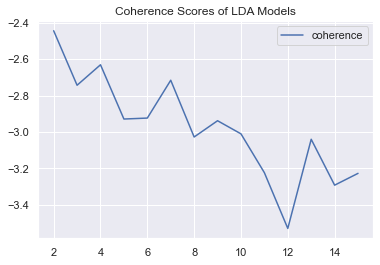

In [61]:
lines = topics_lda.plot.line()
lines.set_title("Coherence Scores of LDA Models")
# the higher the better

In [62]:
# Gensim LDA stores all the text for processing into a corpus object
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# the human annotated coherence
total_topics = 10

# lda model
lda_model = models.LdaModel(corpus, id2word = dictionary, num_topics = total_topics, iterations = 1000, alpha='auto')
# Show first n=10 important words in the topics:
lda_model.show_topics(total_topics, 10)

[(0,
  '0.011*"help" + 0.008*"people" + 0.008*"time" + 0.007*"mental" + 0.007*"month" + 0.007*"anxiety" + 0.007*"ptsd" + 0.006*"health" + 0.005*"anything" + 0.005*"year"'),
 (1,
  '0.014*"time" + 0.008*"work" + 0.008*"day" + 0.007*"life" + 0.006*"help" + 0.006*"anxiety" + 0.005*"new" + 0.005*"mom" + 0.005*"everything" + 0.005*"family"'),
 (2,
  '0.010*"friend" + 0.009*"people" + 0.008*"year" + 0.007*"relationship" + 0.007*"time" + 0.006*"need" + 0.006*"month" + 0.006*"day" + 0.006*"help" + 0.005*"work"'),
 (3,
  '0.015*"work" + 0.011*"time" + 0.010*"survey" + 0.009*"job" + 0.008*"day" + 0.007*"treatment" + 0.005*"call" + 0.005*"year" + 0.005*"month" + 0.004*"life"'),
 (4,
  '0.010*"life" + 0.007*"anxiety" + 0.007*"year" + 0.006*"right" + 0.005*"tired" + 0.005*"away" + 0.005*"live" + 0.005*"people" + 0.004*"friend" + 0.004*"help"'),
 (5,
  '0.011*"year" + 0.009*"friend" + 0.009*"day" + 0.007*"help" + 0.007*"need" + 0.006*"anxiety" + 0.005*"time" + 0.005*"work" + 0.005*"family" + 0.004*"

In [63]:
# Load the topic - term data into an python dictionary
data_lda_model = {i: OrderedDict(lda_model.show_topic(i,10)) for i in range(total_topics)}
data_lda_model

{0: OrderedDict([('help', 0.01123688),
              ('people', 0.008333458),
              ('time', 0.008003797),
              ('mental', 0.0071220654),
              ('month', 0.0071049207),
              ('anxiety', 0.006943896),
              ('ptsd', 0.0068652155),
              ('health', 0.0063754693),
              ('anything', 0.0049327957),
              ('year', 0.0046645314)]),
 1: OrderedDict([('time', 0.01359148),
              ('work', 0.008380576),
              ('day', 0.008109402),
              ('life', 0.0068155904),
              ('help', 0.0062484695),
              ('anxiety', 0.005948458),
              ('new', 0.0050511374),
              ('mom', 0.0049538934),
              ('everything', 0.0049446886),
              ('family', 0.004640354)]),
 2: OrderedDict([('friend', 0.010286975),
              ('people', 0.009142126),
              ('year', 0.007761833),
              ('relationship', 0.0074948403),
              ('time', 0.007105873),
              ('ne

In [64]:
# infer the distribution of topics according to the lda model
topics = []
probs = []
max_to_show = 10

for k, i in enumerate(range(len(texts))):
    try:
        bow = dictionary.doc2bow(texts[i])
        doc_topics = lda_model.get_document_topics(bow, minimum_probability = 0.01)
        # topic with the highest probability
        topics_sorted = sorted(doc_topics, key = lambda x: x[0], reverse = True)
        topics.append(topics_sorted[0][0])
        probs.append("{}".format(topics_sorted[0][1]))

        # Dump out the topic and probability assignments for the first 20 texts
        if k < max_to_show:
            print("Text {}: {}".format(k, topics_sorted))
    except KeyError:
        pass

train_df['LDAtopic'] = pd.Series(topics)
train_df['LDAprob'] = pd.Series(probs)

Text 0: [(9, 0.98344946)]
Text 1: [(3, 0.16442102), (1, 0.82394546)]
Text 2: [(2, 0.98677087)]
Text 3: [(6, 0.98895633)]
Text 4: [(9, 0.8583432), (1, 0.12706602)]
Text 5: [(5, 0.46564963), (1, 0.51070374)]
Text 6: [(9, 0.62101567), (8, 0.28258228), (3, 0.08185991)]
Text 7: [(1, 0.9782052)]
Text 8: [(3, 0.7838306), (2, 0.19756871)]
Text 9: [(6, 0.67862403), (5, 0.29905942)]


In [65]:
# Resort the dataframe according to the human annotated topic and lda topic
train_df.sort_values(['domains', 'LDAtopic'], ascending=[True, True], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
686,ptsd,"[safe, driving, function, enough, grocery, sho...",-0.050000,PTSD,Negative,0.0,0.981013834476471
1358,ptsd,"[son, live, reality, matter, old, son, cant, s...",-0.037727,PTSD,Negative,0.0,0.9763886332511902
1847,ptsd,"[summa, summarum, attacked, guys, without, pro...",0.200000,PTSD,Positive,0.0,0.9804434180259705
121,ptsd,"[time, screw, doctor, episode, phew, sorry, po...",0.113636,PTSD,Positive,0.0,0.972565233707428
1981,ptsd,"[clearly, today, care, issue, shower, month, a...",0.033333,PTSD,Positive,0.0,0.9755078554153442
25,ptsd,"[anything, wrong, sexually, cease, exist, time...",0.022500,PTSD,Positive,0.0,0.9725767374038696
994,ptsd,"[sense, danger, corner, wish, place, dark, rea...",-0.137500,PTSD,Negative,0.0,0.9714027047157288
58,ptsd,"[ptsd, sexual, abuse, week, hard, dr., ford, k...",0.029167,PTSD,Positive,0.0,0.9701453447341919
511,ptsd,"[used, sleeping, pills, anti, anxiety, medicin...",0.559091,PTSD,Positive,0.0,0.9891860485076904
1537,ptsd,"[vtn, inspirational, amazing, work, focus, hon...",0.425000,PTSD,Positive,0.0,0.979263424873352


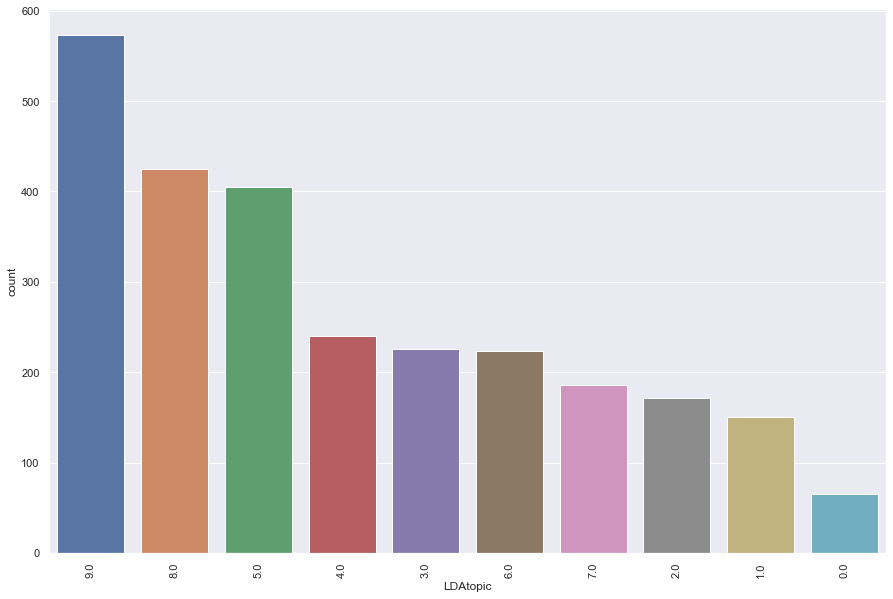

In [66]:
# the distributions of LDA assigned topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='LDAtopic', data=train_df, order = train_df['LDAtopic'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [67]:
# Resort the dataframe according to the the lda assigned topic and the assocoiated probability
train_df.sort_values(['LDAtopic', 'LDAprob'], ascending=[True, False], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
1121,assistance,"[surprise, friend, kindness, strangers, crowd,...",-0.033333,financial,Negative,0.0,0.9898198843002319
511,ptsd,"[used, sleeping, pills, anti, anxiety, medicin...",0.559091,PTSD,Positive,0.0,0.9891860485076904
1862,relationships,"[girlfriend, real, problems, past, month, enjo...",0.181349,social,Positive,0.0,0.9891860485076904
839,domesticviolence,"[chat, therapist, session, need, sort, balance...",0.400000,abuse,Positive,0.0,0.988023579120636
856,survivorsofabuse,"[recognition, emotional, state, quiet, scares,...",0.064286,abuse,Positive,0.0,0.9875965118408203
322,homeless,"[foster, parents, reaching, breaking, point, f...",0.085714,financial,Positive,0.0,0.9868757724761963
47,assistance,"[dental, lifeline, network, donated, dental, s...",0.154167,financial,Positive,0.0,0.9860568046569824
1800,survivorsofabuse,"[abusive, relationship, three, year, ago, awfu...",0.175000,abuse,Positive,0.0,0.9851654171943665
194,domesticviolence,"[beginning, yelling, sick, hospital, refused, ...",-0.069048,abuse,Negative,0.0,0.9833307862281799
827,anxiety,"[weeks, problem, solved, realise, anxious, not...",-0.079545,anxiety,Negative,0.0,0.9829241633415222


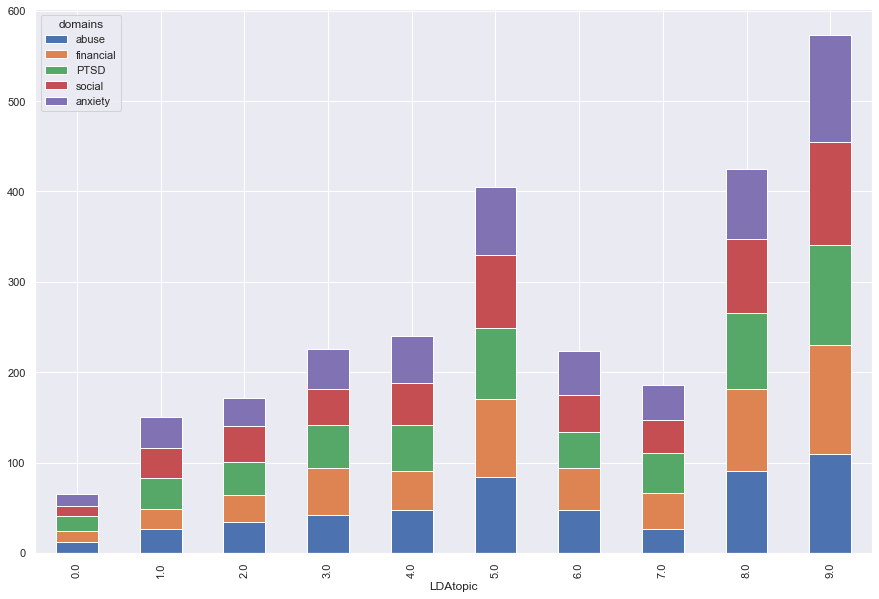

In [68]:
# the topic distrubtions related to the original human annotated/tagged topics
df = train_df.groupby(['LDAtopic', 'domains'])['LDAtopic'].count().unstack('domains')
topic_mixture = df[stress_domains].plot(kind='bar', stacked=True, legend = True)

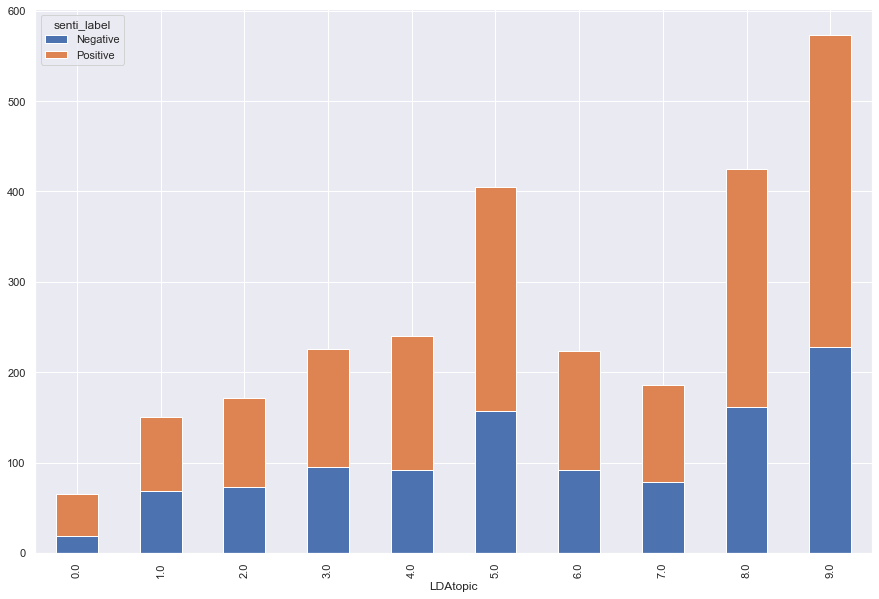

In [69]:
#  the topic distrubtions related to the original human annotated/tagged sentiment
human_sentiment = list(set(train_df['senti_label'].tolist()))
df2 = train_df.groupby(['LDAtopic', 'senti_label'])['LDAtopic'].count().unstack('senti_label')
topic_mixture = df2[human_sentiment].plot(kind='bar', stacked=True, legend = True)

In [70]:
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

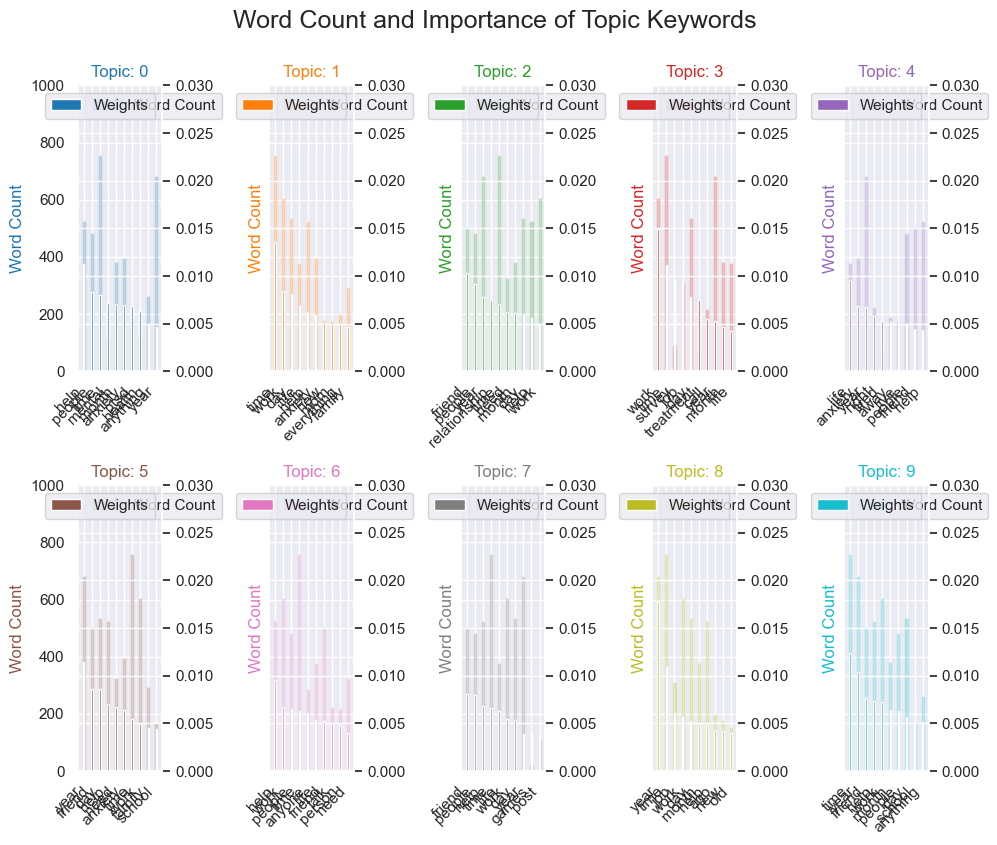

In [71]:
# word count importance of topic keywords
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(10,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=45, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=18, y=1.05)    
plt.show()

In [72]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.044032  0.000897       1        1  14.232355
1      0.046305  0.003081       2        1  12.546298
3      0.048575 -0.023871       3        1  12.259808
2      0.015092 -0.023633       4        1  11.806278
9      0.023820 -0.017889       5        1  11.050888
4      0.014256  0.010308       6        1  10.544405
8      0.041502 -0.025052       7        1   9.418983
0     -0.045347  0.095098       8        1   7.457424
6     -0.063351  0.074760       9        1   6.107185
7     -0.124884 -0.093698      10        1   4.576376, topic_info=          Term        Freq       Total Category  logprob  loglift
75      survey  112.000000  112.000000  Default  30.0000  30.0000
896  treatment  101.000000  101.000000  Default  29.0000  29.0000
117       year  628.000000  628.000000  Default  28.0000  28.0000
296     people  428.000000  428.000000  Default  27.0000  27.0000
51        help  505.000000  505.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
606       need   11.209421  334.549957  Topic10  -5.7994  -0.3118
488      stuff    9.232044  102.238846  Topic10  -5.9935   0.6796
183      month   10.418200  351.725555  Topic10  -5.8726  -0.4350
134     family    9.515026  261.516113  Topic10  -5.9633  -0.2294
562       care    9.111223  140.417725  Topic10  -6.0067   0.3491

[777 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7566      7  0.776533  abandoning
556       1  0.123726       abuse
556       2  0.197962       abuse
556       3  0.057739       abuse
556       4  0.049491       abuse
...     ...       ...         ...
117       6  0.090715        year
117       7  0.216443        year
117       8  0.044562        year
117       9  0.019098        year
117      10  0.022281        year

[2170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 4, 3, 10, 5, 9, 1, 7, 8])

When there are 3 topics in this corpus, these topic clusters achieve the furthest distances, 
indicating the distinguishing differences between these topics.

## Evaluation

Compare the result from the base LDA model and the BERT model based on the Silhouette score

- Silhouette Score: a measure of how similar an object is to its own cluster compared to other clusters. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

- PCA: Linear dimension reduction

- T-SNE: Non-linear dimensional reduction, preserves local structure in the data.

In [85]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [86]:
def reduce_pca(embedding):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embedding)
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(embedding)
    
    return reduced

In [87]:
def get_document_topic_lda(model, corpus, k):
   n_doc = len(corpus)
   #init a vector of size number of docs x clusters
   document_topic_mapping = np.zeros((n_doc, k))
   for i in range(n_doc):
     # for each document create a vector of probability document belonging to topic
     for topic, prob in model.get_document_topics(corpus[i]):
       document_topic_mapping[i, topic] = prob

   return document_topic_mapping

In [88]:
ldamodel = lda_model

In [92]:
embedding_lda = get_document_topic_lda(ldamodel, corpus, total_topics)
for i,topic in enumerate(embedding_lda[10].flatten()):
    print("Topic",i+1,":", embedding_lda[10].flatten()[i])

Topic 1 : 0.04758391156792641
Topic 2 : 0.9364892244338989
Topic 3 : 0.0
Topic 4 : 0.0
Topic 5 : 0.0
Topic 6 : 0.0
Topic 7 : 0.0
Topic 8 : 0.0
Topic 9 : 0.0
Topic 10 : 0.0


In [93]:
labels_lda = []
for line in corpus :
  line_labels = sorted(ldamodel.get_document_topics(line) , key=lambda x: x[1], reverse=True)
  # 1st 0 is for selecting top item, and 2nd 0 is for index of tuple
  top_topic = line_labels[0][0]
  labels_lda.append(top_topic)

In [94]:
embedding_pca_lda = reduce_pca(embedding_lda)
embedding_tsne_lda = reduce_tsne(embedding_lda)

pca explained_variance_  [0.09099504 0.08214229]
pca explained_variance_ratio_  [0.15411474 0.13912118]


In [95]:
print("Silhouette score:" )
print("LDA: ", silhouette_score(embedding_lda, labels_lda) )
print("LDA with PCA: ", silhouette_score(embedding_pca_lda, labels_lda) )
print("LDA with TSNE: ", silhouette_score(embedding_tsne_lda, labels_lda) )

Silhouette score:
LDA:  0.6057737872148597
LDA with PCA:  0.19454235580870477
LDA with TSNE:  0.394926
